In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib.patches as mpatches

__Functions__

In [49]:
def gen_Q(df_LOC):
    '''
    generate Q daily matrix
    '''
    #Compute number of complete users over each window with 1-day timestep
    df_LOC['datetime'] = pd.to_datetime(df_LOC['timestamp'], unit='s')
    df_LOC['date_hour'] = df_LOC['datetime'].dt.floor('h')
    df_LOC['date'] = df_LOC['datetime'].dt.date
    df_LOC_downsampled_1hour = df_LOC[['uid','date','date_hour']].drop_duplicates()
    df_LOC_date_nhours = df_LOC_downsampled_1hour.groupby(['uid','date']).size().reset_index()
    df_LOC_date_nhours.rename(columns = {0:'nhours'}, inplace = True)
    df_LOC_date_nhours['perc_hours'] = df_LOC_date_nhours['nhours']/24
    Q = df_LOC_date_nhours.pivot(index = 'date', 
                                 columns = 'uid', 
                                 values = 'perc_hours').fillna(0)
    return Q

def compute_mean_q(Q, date, SW_width_days):
    '''
    compute average q over a single sliding window iteration 
    that is for a given day, take the window [day, day + SW_width_days] and compute individual q mean for all users
    '''
    #select index corresponding to the date
    i = np.argwhere(Q.index==date).ravel()[0]
    #compute the q mean over the specific sliding window iteration
    return Q[i:i+SW_width_days].mean(axis=0)

def ax_visual_ticklabel(ax, DICT_xtl, axis='x'): 
    xt, xtl, rot, size = (DICT_xtl[c] for c in ['t', 'tl','rot','size'])
    if axis=='x':
        ax.set_xticks(xt)
        ax.set_xticklabels(xtl, rotation = rot, size = size)
    if axis=='y':
        ax.set_yticks(xt)
        ax.set_yticklabels(xtl, rotation = rot, size = size)   

def ax_visual_labeltitles(ax, DICT_lt): 
    xl = DICT_lt['xlabel']
    yl = DICT_lt['ylabel']
    title = DICT_lt['title']
    size_l = DICT_lt['label_size']
    size_t = DICT_lt['title_size']
    ax.set_xlabel(xl, size = size_l)
    ax.set_ylabel(yl, size = size_l)
    ax.set_title(title, size = size_t)

def ax_visual_legend(ax, DICT_legend): 
    Colors = DICT_legend['colors']
    Indicators = DICT_legend['classes']
    Patches = [mpatches.Patch(color=c, label=l)  for c,l in zip(Colors, Indicators)]
    ax.legend(handles= Patches, 
              title=  DICT_legend['title'], 
              loc            = DICT_legend['loc'], 
              fontsize       = DICT_legend['fontsize'],
              title_fontsize = DICT_legend['title_fontsize'])
    

__Construct the Q daily matrix__

Defining q as the fraction of missing hours over a given period. 

- columns: individual
- rows: day
- values: q for an individual at a given day, that is the fraction of hours in the day for which the individual is active

In [50]:
path_LOC = '../data/sample2/sample2.csv'
df_LOC = pd.read_csv(path_LOC)
print(df_LOC.shape)
df_LOC.head(2)

(25835, 4)


,uid,timestamp,latitude,longitude
0,wizardly_joliot,1704119340,38.321711,-36.667334
1,wizardly_joliot,1704119700,38.321676,-36.667365


In [51]:
#Construct daily Q 
Q = gen_Q(df_LOC)
print(Q.shape)
Q.head(2)

(15, 100)


uid,admiring_curie,admiring_pike,adoring_einstein,adoring_northcutt,agitated_chebyshev,agitated_euclid,agitated_golick,amazing_nightingale,angry_johnson,angry_spence,...,vigorous_chaplygin,wizardly_joliot,wonderful_bell,wonderful_nobel,wonderful_swirles,youthful_boyd,youthful_galileo,zealous_cray,zealous_ramanujan,zen_colden
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.0,0.000000,0.208333,0.083333,0.000000,0.000,0.333333,0.333333,0.000000,0.458333,...,0.041667,0.041667,0.083333,0.083333,0.041667,0.041667,0.583333,0.041667,0.083333,0.458333
2024-01-02,0.0,0.041667,0.041667,0.000000,0.333333,0.625,0.208333,0.083333,0.041667,0.583333,...,0.125000,0.458333,0.041667,0.000000,0.250000,0.208333,0.583333,0.083333,0.250000,0.666667


__Perform sliding window Q computation__

In [52]:
#width of the sliding window in days
SW_width_days = 3
#dates involved in the sliding window computation
Dates = Q.index[:-SW_width_days]
#sliding window computation over the time-range of the dataframe
df_Dates= pd.DataFrame(Dates)
Q_window = df_Dates.groupby(['date']).apply(lambda x :  compute_mean_q(Q,x.values[0,0], SW_width_days))
print(Q_window.shape)
Q_window.head(2)

(12, 100)


/tmp/ipykernel_1133865/414401454.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Q_window = df_Dates.groupby(['date']).apply(lambda x :  compute_mean_q(Q,x.values[0,0], SW_width_days))


uid,admiring_curie,admiring_pike,adoring_einstein,adoring_northcutt,agitated_chebyshev,agitated_euclid,agitated_golick,amazing_nightingale,angry_johnson,angry_spence,...,vigorous_chaplygin,wizardly_joliot,wonderful_bell,wonderful_nobel,wonderful_swirles,youthful_boyd,youthful_galileo,zealous_cray,zealous_ramanujan,zen_colden
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.000000,0.013889,0.097222,0.097222,0.388889,0.250000,0.361111,0.263889,0.013889,0.583333,...,0.194444,0.250000,0.041667,0.027778,0.111111,0.152778,0.541667,0.069444,0.236111,0.625000
2024-01-02,0.055556,0.041667,0.125000,0.069444,0.486111,0.277778,0.333333,0.277778,0.055556,0.708333,...,0.180556,0.319444,0.069444,0.013889,0.111111,0.236111,0.569444,0.069444,0.236111,0.736111


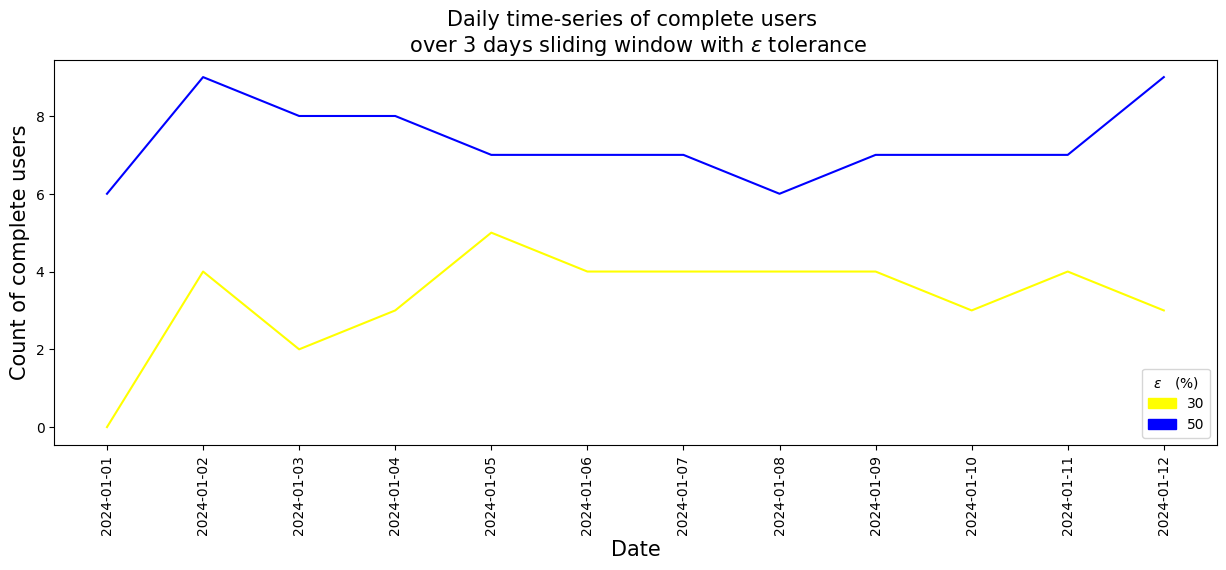

In [68]:
#VISUALIZE DAILY COMPLETE USERS FOR DIFFERENT VALUES OF EPSILON
LIST_eps = [0.3,0.5]
Colors_eps = ['yellow', 'blue']
X = range(len(Dates))

DICT_legend= {'classes': [int(e*100) for e in LIST_eps], 
              'colors': Colors_eps, 
              'loc': 'lower right', 
              'fontsize':10,
              'title': '$\epsilon \quad (\%)$', 
              'title_fontsize':10}

DICT_ticks = {'t': X, 
              'tl': Dates, 
              'rot': 90, 
              'size':10}

DICT_label_titles = {'xlabel': 'Date', 
                     'ylabel': 'Count of complete users', 
                     'title': f'Daily time-series of complete users \n over {SW_width_days} days sliding window with $\epsilon$ tolerance', 
                     'label_size': 15, 
                     'title_size': 15}

fig, ax = plt.subplots(figsize = (15,5))

for eps,color in zip(LIST_eps, Colors_eps):
    #Counts of complete users for each date - based on eps tolerance
    I_complete_eps = (Q_window > (1-eps)).sum(axis=1)
    ax.plot(X, I_complete_eps.values, color = color, label = eps)

ax_visual_legend(ax, DICT_legend)
ax_visual_ticklabel(ax, DICT_ticks, axis = 'x')
ax_visual_labeltitles(ax, DICT_label_titles)